<h2>Описание проекта <a class="tocSkip"> </h2>

**Заказчик** - Стартап по продаже продуктов питания.
    
**Цель проекта:** - изучить поведение пользователей мобильного приложения стартапа.
    
**Задачи проекта:**
- Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследовать результаты A/A/B-эксперимента. Пользователи разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

**Входные данные»** - логи пользователей (каждая запись в логе — это действие пользователя, или событие).
Ниже описаны обозначения столбцов:
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


**План работ:**
<a id="introduction"></a>
- [Откроем файл с данными и изучим общую информацию](#start)
- [Предобработка данных](#preprocessing)
- [Изучение и проверка данных](#analyzing)
- [Изучение воронки событий](#funnel)
- [Исследование результатов A/A/B-эксперимента](#ABexp)
- [Выводы](#conclusion)

### Откроем файл с данными и изучим общую информацию

<a id="start"></a>
[Описание проекта](#introduction)

In [141]:
#Импортируем библиотеку pandas
import pandas as pd

#Импортируем модуль библиотеки matplotlib  pyplot
import matplotlib.pyplot as plt

#Импортируем библиотеку numpy
import numpy as np

#Импортируем из библиотеки scipy  модуль stats
from scipy import stats as st

#Импортируем библиотеку для использования сложных математических формул
import math as mth

#Импортируем библиотеку для работы со временем
import datetime as dt

#Импортируем библиотеку seaborn
import seaborn as sns

# Импортируем библиотеку для графика воронки
import plotly.express as px
#Импортируем  библиотеку warnings и numpy для предотвращения возникновения всплывабщих ошибок
import warnings

#Код для предотвращения всплывающих ошибок
warnings.filterwarnings("ignore")

#Импортируем модули из plotly для вывода графика на nbviewer
from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
init_notebook_mode(connected=True)

In [142]:
#Сохраним датасет в переменную 'data'
data = pd.read_csv('logs_exp.csv', sep='\t')

In [143]:
#Выведем первые 5 строк для ознакомления
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Необходимо:
- Привести наименования столбцов к нижнему регистру
- Перевести время в столбце `EventTimestamp` из формата `timestamp` в формат `datetime`

In [144]:
#Выведем общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных нету, датасет насчитывает 244 126 строк

In [145]:
#Проверим данные на наличие дубликатов
data.duplicated().sum()

413

Нашлось 413 дублирующихся записи, вероятно, из - за какой - то технической ошибки произошло дублирование одного и того же действия, следует их удалить (дубликаты составляют менее 1% от всех данных), а также сообщить о дубликатах сотрудникам, которые занимались сбором данных

In [146]:
#Проверим столбец EventName на наличие неявных дубликатов
data['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Неявных дубликатов не обнаружилось

(array([245.75, 246.  , 246.25, 246.5 , 246.75, 247.  , 247.25, 247.5 ,
        247.75, 248.  , 248.25]),
 [Text(245.75, 0, '245.75'),
  Text(246.0, 0, '246.00'),
  Text(246.25, 0, '246.25'),
  Text(246.5, 0, '246.50'),
  Text(246.75, 0, '246.75'),
  Text(247.0, 0, '247.00'),
  Text(247.25, 0, '247.25'),
  Text(247.5, 0, '247.50'),
  Text(247.75, 0, '247.75'),
  Text(248.0, 0, '248.00'),
  Text(248.25, 0, '248.25')])

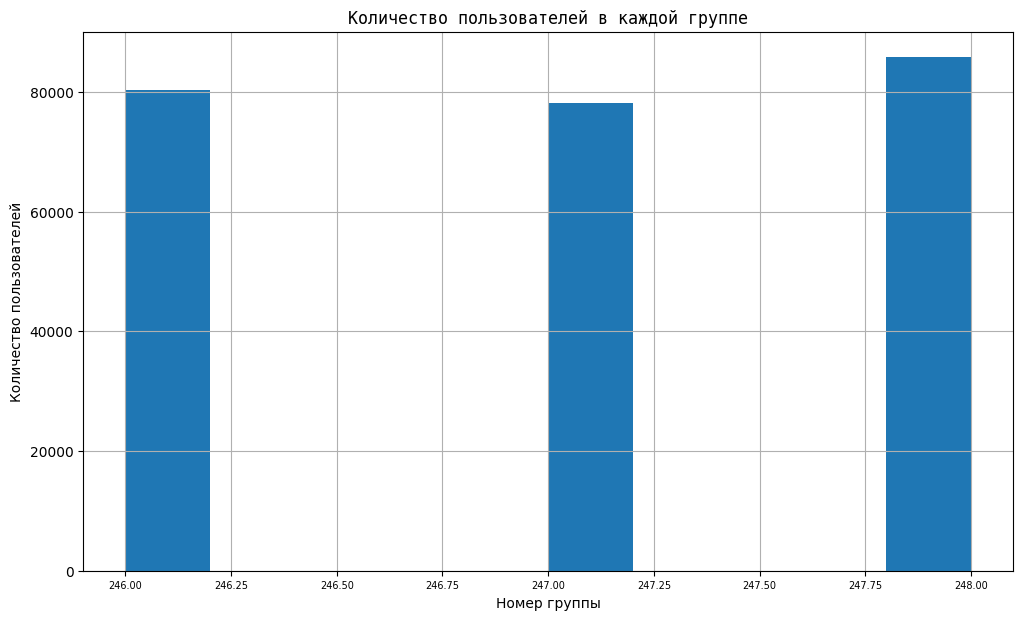

In [147]:
#Изучим столбец с номерами экспериментов
fig, ax = plt.subplots()
ax.grid()

plt.hist(x=data['ExpId'])
ax.set_xlabel('Номер группы')
ax.set_ylabel('Количество пользователей')
fig.set_figwidth(12)
fig.set_figheight(7)
#Добавляем заголовок графику
ax.set_title('Количество пользователей в каждой группе',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 12)
plt.xticks(fontsize = 7)

In [148]:
data['ExpId'].value_counts()

248    85747
246    80304
247    78075
Name: ExpId, dtype: int64

- В датасете только 3 номера экспериментов, лишних не наблюдается
- Данные по группам распределенны практически одинаково (экспериментальная чуть больше двух контрольных групп - на 6% и 8% в 246 и 247 группах, соответственно)

### Предобработка данных

<a id="preprocessing"></a>
[Описание проекта](#introduction)

In [149]:
data = data.rename(columns={'EventName': 'event_name',
                    'DeviceIDHash': 'device_id_hash',
                    'EventTimestamp': 'event_timestamp',
                    'ExpId': 'exp_id'})

In [150]:
#Удаляем дубликаты
data = data.drop_duplicates()

In [151]:
#Добавим новый столбец с датой и временем
data['date_time'] = pd.to_datetime(data['event_timestamp'], unit='s')
#Добавим новый столбец с датой
data['date'] = data['date_time'].dt.date

In [152]:
#Проверим, что новые столбцы добавились
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


In [153]:
#Выведем первые 5 строк
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


### Изучение и проверка данных

<a id="analyzing"></a>
[Описание проекта](#introduction)

#### Количество событий в логах

In [154]:
# Выше уже было посчитано количество строк с удаленными дубликатами, посчитаем еще раз
events_before = data.shape[0]
events_before

243713

`243713` - всего событий в логе

#### Количество пользователей в логе

In [155]:
#Посчитаем количество пользователей
users_before = data['device_id_hash'].nunique()
users_before

7551

`7551` - всего пользователей в логе

#### Среднее количество событий на пользователя

In [156]:
round(data.pivot_table(index='device_id_hash', values='event_name', aggfunc='count').mean())

event_name    32.0
dtype: float64

`32` - событий в среднем на одного пользователя

#### Анализ периода в котором лежат наши данные

In [157]:
#Найдем минимальную дату
data['date'].min()

datetime.date(2019, 7, 25)

Самое раннее событие - `25 июля 2019 год`

In [158]:
#Найдем максимальную дату
data['date'].max()

datetime.date(2019, 8, 7)

Самое позднее событие - `7 августа 2019 год`

(array([18102., 18104., 18106., 18108., 18109., 18111., 18113., 18115.]),
 [Text(18102.0, 0, '2019-07-25'),
  Text(18104.0, 0, '2019-07-27'),
  Text(18106.0, 0, '2019-07-29'),
  Text(18108.0, 0, '2019-07-31'),
  Text(18109.0, 0, '2019-08-01'),
  Text(18111.0, 0, '2019-08-03'),
  Text(18113.0, 0, '2019-08-05'),
  Text(18115.0, 0, '2019-08-07')])

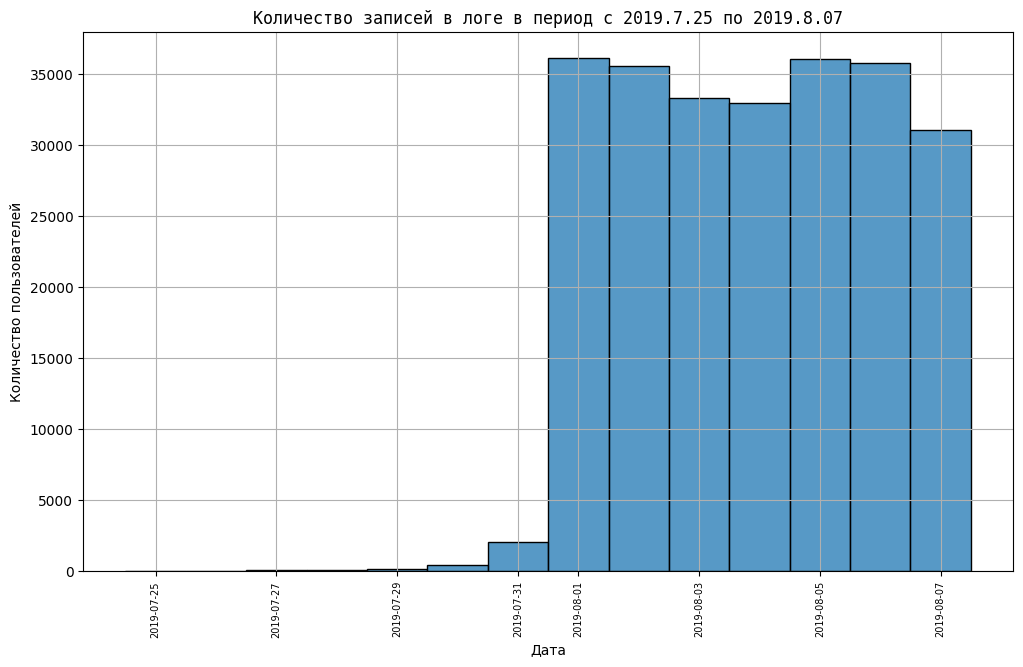

In [159]:
#Построим гистограммму, на которой отражего количество записей в логе в период с 2019.7.25 по 2019.8.07
fig, ax = plt.subplots()
ax.grid()
sns.histplot(x=data['date'], bins=14)
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')

fig.set_figwidth(12)
fig.set_figheight(7)
# #Добавляем заголовок графику
ax.set_title('Количество записей в логе в период с 2019.7.25 по 2019.8.07',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 12)
plt.xticks(fontsize = 7, rotation=90)


In [160]:
#Построим сводную таблицу для подсчета событий
data.pivot_table(
    index='date', values='event_name', aggfunc='count').rename(columns={'event_name': 'cnt_events'})

,cnt_events
date,
2019-07-25,9
2019-07-26,31
2019-07-27,55
2019-07-28,105
2019-07-29,184
2019-07-30,412
2019-07-31,2030
2019-08-01,36141
2019-08-02,35554


На гистаграмме видно что основная масса записей была зарегестрированна в период с 2019-08-01 по 2019-08-07, также это подтверждает наша сводная таблица. Следовательно, у нас не одинаково полные данные за весь период, мы можем отбросить данные в период с 2019-07-25 по 2019-07-31 включительно, так как они являются неполными (делаем это для того, чтобы это не создавало перекосов в нашем исследовании).

#### Подсчет потерь количества событий и уникальных пользователей

In [161]:
#Для начала обновим наш датасет, удалив лишние данные
data = data[data['date_time'] >= '2019-08-01']

In [162]:
#Проверим, что в датасете остались данные за интересующий нас период
data.pivot_table(index='date',
 values='event_name', aggfunc='count').rename(columns={'event_name': 'cnt_events'})

,cnt_events
date,
2019-08-01,36141
2019-08-02,35554
2019-08-03,33282
2019-08-04,32968
2019-08-05,36058
2019-08-06,35788
2019-08-07,31096


In [163]:
print('Количество потерянных событий:',events_before - data.shape[0])
print('Процент потерянных событий:',round((events_before - data.shape[0]) / events_before * 100,2))

Количество потерянных событий: 2826
Процент потерянных событий: 1.16


Процент потерянных событий очень мал и за период в 7 дней составляет 1.16% от всех событий, потери допустимы в пределах 5%.

In [164]:
print('Количество потерянных пользователей:',users_before - data['device_id_hash'].nunique())
print('Процент потерянных пользователей:',round(
    (users_before - data['device_id_hash'].nunique()) / users_before * 100,2))

Количество потерянных пользователей: 17
Процент потерянных пользователей: 0.23


Процент потерянных пользователей также очень мал и за период в 7 дней составляет всего 0.23% от всех событий, потери допустимы в пределах 5%.

(array([245.75, 246.  , 246.25, 246.5 , 246.75, 247.  , 247.25, 247.5 ,
        247.75, 248.  , 248.25]),
 [Text(245.75, 0, '245.75'),
  Text(246.0, 0, '246.00'),
  Text(246.25, 0, '246.25'),
  Text(246.5, 0, '246.50'),
  Text(246.75, 0, '246.75'),
  Text(247.0, 0, '247.00'),
  Text(247.25, 0, '247.25'),
  Text(247.5, 0, '247.50'),
  Text(247.75, 0, '247.75'),
  Text(248.0, 0, '248.00'),
  Text(248.25, 0, '248.25')])

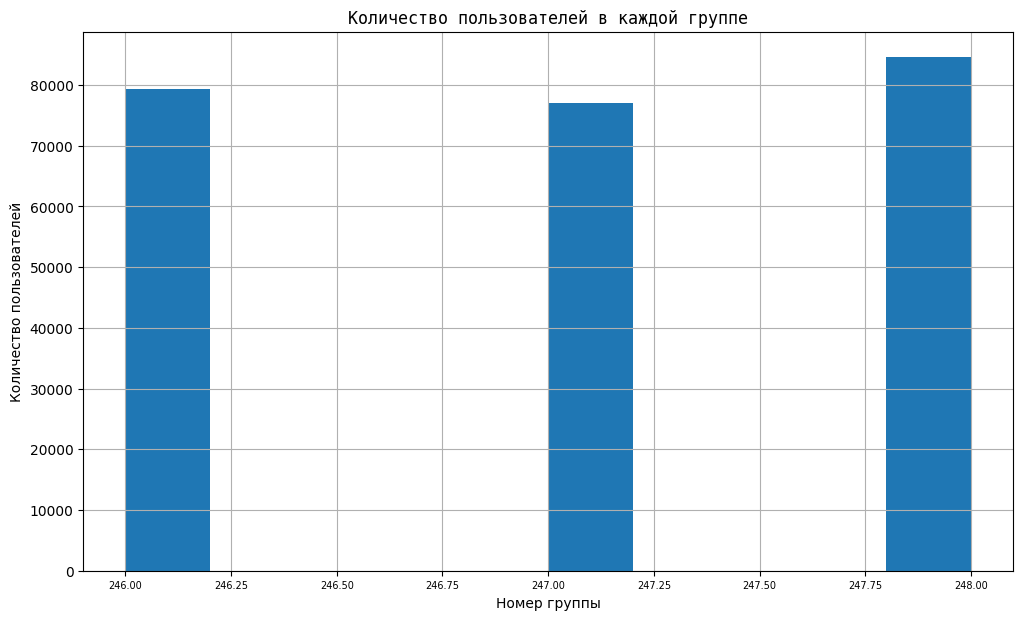

In [165]:
#Проверим, все ли группы у нас остались после отсчечения данных
fig, ax = plt.subplots()
ax.grid()

plt.hist(x=data['exp_id'])
ax.set_xlabel('Номер группы')
ax.set_ylabel('Количество пользователей')
fig.set_figwidth(12)
fig.set_figheight(7)
#Добавляем заголовок графику
ax.set_title('Количество пользователей в каждой группе',
                fontfamily = 'monospace',
                fontstyle = 'normal',
                fontsize = 12)
plt.xticks(fontsize = 7)

Да, с учетом посчитанных потерь, у нас есть пользователи из всех эксперементальных групп

### Изучение воронки событий

<a id="funnel"></a>
[Описание проекта](#introduction)

In [166]:
#Изучим частоту событий, встречающихся в логах
freq_events = data.pivot_table(
    index = 'event_name',
    values= 'device_id_hash',
    aggfunc='count').sort_values('device_id_hash',ascending=False)
freq_events = freq_events.rename(columns={'device_id_hash': 'cnt_events'})
freq_events['frequency'] = round(freq_events['cnt_events'] / freq_events['cnt_events'].sum(), 3)
freq_events

,cnt_events,frequency
event_name,,
MainScreenAppear,117328,0.487
OffersScreenAppear,46333,0.192
CartScreenAppear,42303,0.176
PaymentScreenSuccessful,33918,0.141
Tutorial,1005,0.004


Рейтинг по количеству событий:
- MainScreenAppear (Заход на главный экран приложения) - 117 328 (48.7%)
- OffersScreenAppear (Можно предположить, что это - Показ товаров магазина пользователям) - 46 333 (19.2%)
- CartScreenAppear (Заход в собранную корзину с выбранными товарами) - 42 303 (17.6%)
- PaymentScreenSuccessful (Показ баннера "Оплата прошла успешно") - 33 918 (14.1%)
- Tutorial (Показ туториала по приложению) - 1005 (0.4%)

In [167]:
#Посчитаем число уникальных пользователей после очистки датасета
#Будем использовать для нахождения конверсии
users_after = data['device_id_hash'].nunique()

In [168]:
#Посчитаем число пользователей, совершивших каждое событие, а также их долю
users_count = data.groupby(
    'event_name').agg(
        {'device_id_hash': 'nunique'}).sort_values(
            by='device_id_hash', ascending=False).rename(columns={'device_id_hash': 'cnt_un_users'})
users_count['users_per'] = round(users_count['cnt_un_users'] / users_after, 3)
users_count

,cnt_un_users,users_per
event_name,,
MainScreenAppear,7419,0.985
OffersScreenAppear,4593,0.610
CartScreenAppear,3734,0.496
PaymentScreenSuccessful,3539,0.470
Tutorial,840,0.111


Рейтинг по количеству пользователей, совершавших данное событие:
- MainScreenAppear - 7419 (98.5%)
- OffersScreenAppear - 4593 (61%)
- CartScreenAppear - 3734 (49.6%)
- PaymentScreenSuccessful - 3539 (47%)
- Tutorial - 840 (11.1%)

Вероятнее всего, пользовательский путь имеет следующий порядок событий:
- MainScreenAppear (Пользователь заходит на главный экран приложения)
- OffersScreenAppear (Пользователь смотрит товары магазина / предложенные товары магазином)
- CartScreenAppear (Пользователь заходит в собранную корзину с выбранными товарами) 
- PaymentScreenSuccessful (После оплаты пользователю показывается баннер "Оплата прошла успешно")
- Tutorial (Прохождение пользователем туториала по использованию приложения. По количеству событий а также уникальных пользователей, совершивших это событие, можем сделать предположение о том, что оно опционально и не является обязательным пунктом для осуществления покупок в приложении)

#### Воронка событий

In [169]:
#Удалим опциональную строку с туториалом, а также долю пользователей в каждом событии
users_count = users_count.drop(index='Tutorial', columns='users_per')

In [170]:
#Добавляем сдвинутый столбец количества уникальных пользователей
#для расчета конверсии и конверсии за шаг.
#Заполним пустое значение количеством уникальных пользователей на самом первом событии,
#делаем это для того, чтобы было 100% на старте
users_count['count_f_cr'] = users_count['cnt_un_users'].shift(1).fillna(users_count['cnt_un_users'][0])

In [171]:
#Расчитываем обычную конверсию
users_count['conversion'] = round(users_count['cnt_un_users'] / users_count['count_f_cr'][0] * 100, 2)
#Расчитываем конверсию в шаг
users_count['cr_step'] = round(users_count['cnt_un_users'] / users_count['count_f_cr'] * 100, 2)
#Расчитываем потерю пользователей в процентах в шаг
users_count['lost_cr_step'] = 100 - round(users_count['cnt_un_users'] / users_count['count_f_cr'] * 100, 2)

In [172]:
#Выведем итоговую таблицу
users_count

,cnt_un_users,count_f_cr,conversion,cr_step,lost_cr_step
event_name,,,,,
MainScreenAppear,7419,7419.0,100.00,100.00,0.00
OffersScreenAppear,4593,7419.0,61.91,61.91,38.09
CartScreenAppear,3734,4593.0,50.33,81.30,18.70
PaymentScreenSuccessful,3539,3734.0,47.70,94.78,5.22


In [173]:
#Для большей наглядности построим воронку для отражения количества пользователей
#на каждом этапе
fig = px.funnel(users_count['cnt_un_users'])
fig.update_layout(title='Конверсия пользователей в приложении на каждом этапе',
                   yaxis_title='Название события')
iplot(fig)

In [174]:
#Для большей наглядности построим воронку для конверсии в шаг
#на каждом этапе
fig = px.funnel(users_count['cr_step'])

fig.update_layout(title='Конверсия в шаг пользователей в приложении на каждом этапе (%)',
                   yaxis_title='Название события')
iplot(fig)

Конверсия в шаг:
- MainScreenAppear - 100.00 (100%, потому что это самое первое действие)
- `OffersScreenAppear - 61.91 (на данном этапе мы теряем больше всего пользователей - 38.09%)`
- CartScreenAppear - 81.30 (81.3% пользователей, посмотревших товары, добавляют их в корзину)
- PaymentScreenSuccessful - 94.78 (почти 95% пользователей которые перешли в корзину, осуществили заказ)

**Вывод:**
`47.7%` пользователей нашего приложения дошли от главного экрана приложения до оплаты, мы можем назвать данный резулат отличным, ведь практически `50%` пользователей, скачавших приложение, совершили в нем покупки. Но данный результат можно улучшить, ведь наши пользователи почему - то "застревают" на главном экране и не переходят в другое окно для просмотра товаров (`38.09%`). Необходимо изучить действия, которые совершает пользователь для перехода к выбору товаров и ,возможно, стоит поработать над интуитивной частью приложения или сделать подсказки (помимо туториала, который проходят очень мало людей, возможно, стоит сделать всплывающее окно с туториалом, если такогового нету, после самого первого запуска приложения).

### Исследование результатов A/A/B-эксперимента

<a id="ABexp"></a>
[Описание проекта](#introduction)

#### Количество пользователей в каждой эксперементальный группе

In [175]:
cnt_all_us = data.groupby('exp_id').agg(
        {'device_id_hash':'nunique'}).rename(columns={'device_id_hash': 'un_users'})
cnt_all_us

,un_users
exp_id,
246,2484
247,2513
248,2537


- Группа 246(A) - `2484` пользователей
- Группа 247(A) - `2513` пользователей
- Группа 248(B) - `2537` пользователей

#### Проверка на пользователей, состощих в нескольких группах A/A/B - тестирования

In [176]:
#Напишем цикл, который обнаружит пользователей, которые попали в две или более выборки A/A/B - тестирования
povtor_us = data.pivot_table(index=['device_id_hash', 'exp_id'])
userAB = []
for _ in range(len(povtor_us)):
    if povtor_us.index[_][0] == povtor_us.index[_ - 1][0]:
        if povtor_us.index[_][1]!=povtor_us.index[_ - 1][1]:
            userAB.append(povtor_us.index[_][0])

In [177]:
#Посчитаем этих пользователей
pd.Series(userAB).count()

0

Проверка выявила то, что каждый пользователь состоит в одной группе, можем сделать вывод о том, что на протяжении всего A/A/B - тестирования данные собирались корректно

#### Разница между выборками 246 и 247

In [178]:
#Сформируем таблицу, содержащую данные по уникальным пользователям
#на каждое событие в 246 группе
data_246 = data[
    data['exp_id']==246].groupby('event_name').agg(
        {'device_id_hash':'nunique'}).sort_values(
            'device_id_hash', ascending=False).rename(
                columns={'device_id_hash':'group_246'})

In [179]:
#Выведем таблицу 
data_246

,group_246
event_name,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200
Tutorial,278


In [180]:
#Сформируем таблицу, содержащую данные по уникальным пользователям
#на каждое событие в 247 группе
data_247 = data[
    data['exp_id']==247].groupby('event_name').agg(
        {'device_id_hash':'nunique'}).sort_values(
            'device_id_hash', ascending=False).rename(
                columns={'device_id_hash':'group_247'})

In [181]:
#Выведем таблицу
data_247

,group_247
event_name,
MainScreenAppear,2476
OffersScreenAppear,1520
CartScreenAppear,1238
PaymentScreenSuccessful,1158
Tutorial,283


Сформулируем наши гипотезы о равенстве долей и проверим их, предположим в нулевой гипотезе, что наши выборки одинаковые и пропорции покупок в приложении равны, а в альтернативной не равны.

- Н0: Доля покупок в группе 246 == Доля покупок в группе 247
- Н1: Доля покупок в группе 246 != Доля покупок в группе 247

In [182]:
alpha = 0.05  # критический уровень статистической значимости

In [183]:
#Платежи в группе 246 и 247
payments = np.array([data_246['group_246'][3], data_247['group_247'][3]])

#Всего открытий главного приложения для группы 246 и 247
leads = np.array([data_246['group_246'][0], data_247['group_247'][0]])

In [184]:
# Пропорция успехов в первой группе:
p1 = payments[0]/leads[0]

# Пропорция успехов во второй группе:
p2 = payments[1]/leads[1]

In [185]:
# Пропорция успехов в комбинированном датасете:
p_combined = (payments[0] + payments[1]) / (leads[0] + leads[1])

In [186]:
# Разница пропорций в датасетах
difference = p1 - p2 
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
distr = st.norm(0, 1)

In [187]:
# Расчитаем p-value
p_value = (1 - distr.cdf(abs(z_value))) * 2

In [188]:
print('p-значение: {0:.03f} '.format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

p-значение: 0.120 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение = `~12%`, это значительно больше нашего критического уровня статистической значимости, следовательно, мы не может отвергать нашу нулевую гипотезу, делаем вывод о том, что доли покупок в контрольных группах равны.

In [189]:
#Сформируем таблицу, содержащую данные по уникальным пользователям
#на каждое событие в 248 группе
data_248 = data[
    data['exp_id']==248].groupby('event_name').agg(
        {'device_id_hash':'nunique'}).sort_values(
            'device_id_hash', ascending=False).rename(
                columns={'device_id_hash':'group_248'})

In [190]:
#Выведем таблицу
data_248

,group_248
event_name,
MainScreenAppear,2493
OffersScreenAppear,1531
CartScreenAppear,1230
PaymentScreenSuccessful,1181
Tutorial,279


In [191]:
#Сформируем таблицу, содержащую данные по объединенной контрольной группе
data_246_247 = data[(data['exp_id']==246) | (data['exp_id']==247)].groupby('event_name').agg(
        {'device_id_hash':'nunique'}).sort_values(
            'device_id_hash', ascending=False).rename(
                columns={'device_id_hash':'group_246_247'})

In [192]:
#Выведем таблицу
data_246_247

,group_246_247
event_name,
MainScreenAppear,4926
OffersScreenAppear,3062
CartScreenAppear,2504
PaymentScreenSuccessful,2358
Tutorial,561


In [193]:
#Объединим все выборки в один датасет для удобства работы
#Также удалим Строку Tutorial, т.к. это событие не является частью основного клиентского пути

all_groups = (
    data_246
    .merge(
        data_247,
        how='inner',
        left_index=True,
        right_index=True)
    .merge(
        data_248,
        how='inner',
        left_index=True,
        right_index=True)
    .merge(
        data_246_247,
        how='inner',
        left_index=True,
        right_index=True)

    ).drop(index='Tutorial')

In [194]:
# Число пользователей, совершивших это событие в каждом из событий
all_groups

,group_246,group_247,group_248,group_246_247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [195]:
#Проведем визуализацию таблицы в виде воронки
fig = px.funnel(all_groups.drop(columns={'group_246_247'}))
fig.update_layout(title='Конверсия пользователей в приложении на каждом этапе',
                   yaxis_title='Название события')
iplot(fig)

In [196]:
#Добавим в наш датасет, хранящий уникальное количество пользователей на каждом этапе,
#значение суммы двух контрольных групп для построения функции нахождения отличия между группами
cnt_all_us.loc['246_247'] = cnt_all_us.loc[246] + cnt_all_us.loc[247]

In [197]:
#Проверим
cnt_all_us

,un_users
exp_id,
246,2484
247,2513
248,2537
246_247,4997


In [198]:
# Сделаем подмену идексов для того, чтобы на вход функции поступали
#одинаковые значения
cnt_all_us['names'] = ['group_246', 'group_247', 'group_248', 'group_246_247']

In [199]:
cnt_all_us = cnt_all_us.set_index('names')

In [200]:
cnt_all_us

,un_users
names,
group_246,2484
group_247,2513
group_248,2537
group_246_247,4997


#### Функция проверки

In [201]:
# Напишем функцию, для всех событий
def function_p_value(group_name_1, group_name_2, alpha):
    alpha = alpha
    for i in all_groups.index:
        payments = np.array([all_groups[group_name_1][i], all_groups[group_name_2][i]])
        leads = np.array([cnt_all_us.loc[group_name_1][0], cnt_all_us.loc[group_name_2][0]])
        # Пропорция успехов в первой группе:
        p1 = payments[0]/leads[0]
        # Пропорция успехов во второй группе:
        p2 = payments[1]/leads[1]
        # Пропорция успехов в комбинированном датасете:
        p_combined = (payments[0] + payments[1]) / (leads[0] + leads[1])
        # Разница пропорций в датасетах
        difference = p1 - p2 
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
        distr = st.norm(0, 1)
        # Расчитаем p-value
        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: {0:.03f} '.format(p_value))

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            )

Н0: Конверсия в шаг группы 246 == Конверсия в шаг группы 247

Н1: Конверсия в шаг группы 246 != Конверсия в шаг группы 247

In [202]:
#Выполним проверку для всех событий для определения того, есть ли статистически достоверные отличия
#Между двумя контрольными группами
function_p_value('group_246', 'group_247', 0.05)

p-значение: 0.757 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.248 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.229 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.115 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Промежуточный вывод про контрольные группы:**

Во всех случаях не получилось отвергнуть нулевую гипотезу, значит конверсии на каждом шаге у групп 246 и 247 равны, соответсвенно, различий между группами нету. На основании этого мы можем считать, что разбиение на группы работает корректно.

#### Сравнение группы 246 и группы 248

Н0: Конверсия в шаг группы 246 == Конверсия в шаг группы 248

Н1: Конверсия в шаг группы 246 != Конверсия в шаг группы 248

In [203]:
function_p_value('group_246', 'group_248', 0.05)

p-значение: 0.295 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.208 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.078 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.212 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Промежуточный вывод про сравнение контрольной группы 246 и эксперементальной:**

Во всех случаях не получилось отвергнуть нулевую гипотезу, значит конверсии на каждом шаге у групп 246 и 248 равны, соответсвенно, различий между группами нету.

#### Сравнение группы 247 и группы 248

Н0: Конверсия в шаг группы 247 == Конверсия в шаг группы 248

Н1: Конверсия в шаг группы 247 != Конверсия в шаг группы 248

In [204]:
function_p_value('group_247', 'group_248', 0.05)

p-значение: 0.459 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.920 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.579 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.737 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Промежуточный вывод про сравнение контрольной группы 247 и эксперементальной:**

Во всех случаях не получилось отвергнуть нулевую гипотезу, значит конверсии на каждом шаге у групп 246 и 248 равны, соответсвенно, различий между группами нету.

#### Сравнение группы 248 с объедниненной контрольной группой

Н0: Конверсия в шаг в объединенной контрольной группе == Конверсия в шаг группы 248

Н1: Конверсия в шаг в объединенной контрольной группе != Конверсия в шаг группы 248

In [205]:
function_p_value('group_248', 'group_246_247', 0.05)

p-значение: 0.294 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.434 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.182 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.600 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Промежуточный вывод про сравнение объединенной контрольной группы  и эксперементальной:**

Во всех случаях не получилось отвергнуть нулевую гипотезу, значит конверсии на каждом шаге у объединенной контрольной группы и 248 равны, соответсвенно, различий между группами нету.

Из данного эксперимента можно сделать вывод о том, что `изменение шрифта никак не повлияло на конверию в приложении стартапа`, во всех экспериментах не получилось отвергнуть гипотезу о том, что группы равны, это наблюдалось как в сравнении эксперементальной группы с контрольной группой 246, так и в сравнении с группой 247. Сравнение группы, где были объединенны пользователи двух контрольных, с группой 248 также показало нам то, что между ними нету статистически достоверных различий.

#### Проверка статистических гипотез при уровне значимости 0.1

Проведем все те же самые сравнения групп, но уже с более лояльным подходом (при уровне значимости в 0.1 отвергнуть нулевую гипотезу о равенстве гораздо проще).

--------------------------------------

Н0: Конверсия в шаг группы 246 == Конверсия в шаг группы 248

Н1: Конверсия в шаг группы 246 != Конверсия в шаг группы 248

In [206]:
function_p_value('group_246', 'group_248', 0.1)

p-значение: 0.295 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.208 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.078 
Отвергаем нулевую гипотезу: между долями есть значимая разница
p-значение: 0.212 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнение групп 246 и 248 выявило отличие только в одном пункте, это разница в перешедших пользователях от просмотра товаров к корзине для совершения оплаты.

--------------------------------------

Н0: Конверсия в шаг группы 247 == Конверсия в шаг группы 248

Н1: Конверсия в шаг группы 247 != Конверсия в шаг группы 248

In [207]:
function_p_value('group_247', 'group_248', 0.1)

p-значение: 0.459 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.920 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.579 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.737 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Во всех случаях не получилось отвергнуть нулевую гипотезу, значит конверсии на каждом шаге у группы 247 и 248 равны при уровне значимости 0.1, соответсвенно, различий между группами нету.

--------------------------------------

Н0: Конверсия в шаг в объединенной контрольной группе == Конверсия в шаг группы 248

Н1: Конверсия в шаг в объединенной контрольной группе != Конверсия в шаг группы 248

In [208]:
function_p_value('group_246_247', 'group_248', 0.1)

p-значение: 0.294 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.434 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.182 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение: 0.600 
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Во всех случаях не получилось отвергнуть нулевую гипотезу, значит конверсии на каждом шаге у объединенной контрольной группы  и эксперементальной равны при уровне значимости 0.1, соответсвенно, различий между группами нету.

### Выводы

<a id="conclusion"></a>
[Описание проекта](#introduction)

- В ходе исследования была изучена общая информация о данных, а также осуществленна их предобработка для последующего анализа.
- Для проведения исследования были отобраны данные в период с 2019-08-01 по 2019-08-07. Это было сделано для того, чтобы в нашем исследовании не было перекосов из - за отсутствия полных данных в период с 2019-07-25 по 2019-07-31.

- После изучения воронки продаж можно сделать следующее заключение - `47.7%` пользователей нашего приложения дошли от главного экрана приложения до оплаты, мы можем назвать данный резулат отличным, ведь практически `50%` пользователей, скачавших приложение, совершили в нем покупки. Но данный результат можно улучшить, ведь наши пользователи почему - то "застревают" на главном экране и не переходят в другое окно для просмотра товаров (`38.09%`). Необходимо изучить действия, которые совершает пользователь для перехода к выбору товаров и ,возможно, стоит поработать над интуитивной частью приложения или сделать подсказки (помимо туториала, который проходят очень мало людей, возможно, стоит сделать всплывающее окно с туториалом, если такогового нету, после самого первого запуска приложения).

- Было сделано 16 проверок статистических гипотез при уровне значимости 0.05. Результаты всех проверок сообщают нам о том, что между контрольными и эксперементальной группой нету разницы.

- Было сделано 12 проверок статистических гипотез при уровне значимости 0.1. Результаты всех проверок также сообщают нам о том, что между контрольными и эксперементальной группой нету разницы (за исключением сравнения групп 246 и 248, где было выявлено отличие только в одном пункте - это разница в перешедших пользователях от просмотра товаров к корзине для совершения оплаты). Но из - за того, что при уровне значимости 0.1 каждый десятый раз можно получать ложный результат, стоит оставить и применять уровень значимости 0.05, т.к. такой уровень даст более точные результаты.

- Из данного A/A/B-эксперимента можно сделать вывод о том, что `изменение шрифта никак не повлияло на конверию в приложении стартапа`, во всех экспериментах не получилось отвергнуть гипотезу о том, что группы равны, это наблюдалось как в сравнении эксперементальной группы с контрольной группой 246, так и в сравнении с группой 247. Значит, новый шрифт не отпугнул пользователей, менеджерам не о чем беспокоиться.

